# Reproducing Biomedical Image Segmentation in the U-Net paper

In this notebook we try to fully reproduce the method presented in the paper ["U-Net: Convolutional Networks for Biomedical Segmentation"](https://arxiv.org/pdf/1505.04597.pdf), particularly, the results presented in table 2 and the pixel error of the U-Net reported in table 1.
The following implementation was carried out without using the pre-existing code, made available by the authors.

## How does U-Net work ?

explain the architecture and challenge (see also video presentation)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import cv2 as cv
import os
import shutil
from batchgenerators.utilities.file_and_folder_operations import maybe_mkdir_p

from torchvision.utils import save_image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from data import download_all_data, ImageDataset, ImageDataset_test
from network import Unet
from functions import weighted_map, input_size_compute, evaluation_metrics

from time import time

CUR_DIR = os.path.abspath('')

# Dataset


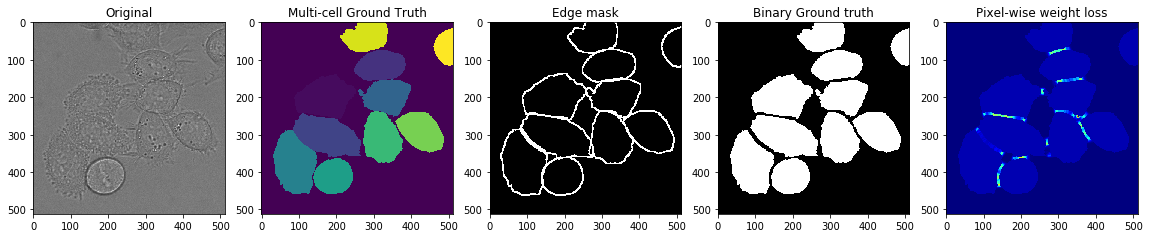

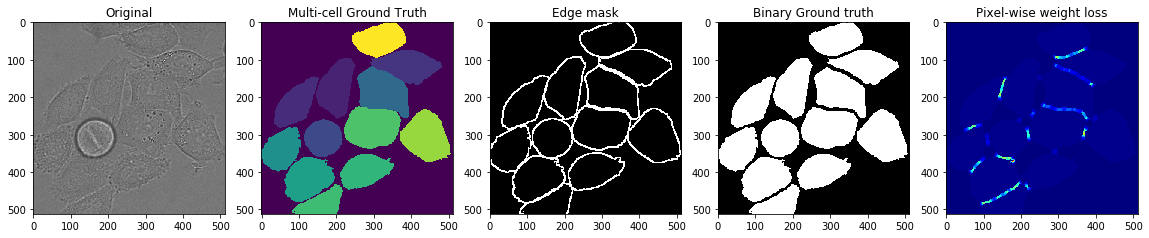

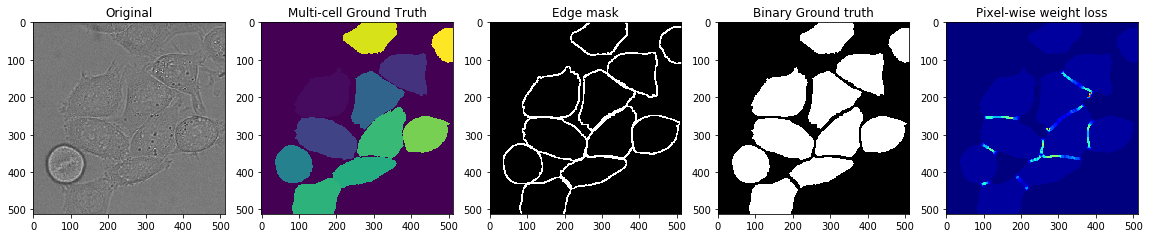

In [2]:
# Download data
download_all_data()

# Specify which dataset to analyse
# DATASET = 'PhC-C2DH-U373'
# DATASET = 'ISBI2012'
DATASET = 'DIC-C2DH-HeLa'

ISBI2012 = False

if DATASET is 'ISBI2012':
    ISBI2012 = True

target_path = os.path.join(CUR_DIR, "data", f"{DATASET}-training", "01_ST", "SEG")
target_GT_path = os.path.join(CUR_DIR, "data", f"{DATASET}-training", "01_GT", "SEG")
training_path = os.path.join(CUR_DIR, "data", f"{DATASET}-training", "01")
target_GT = os.listdir(target_GT_path)

for image in target_GT:
    os.remove(os.path.join(target_path, image))    

target = os.listdir(target_path)

for image in target_GT:
    shutil.copyfile(os.path.join(target_GT_path, image), os.path.join(target_path, image))

for i in range(3):
    # load images
    img_training = cv.imread(os.path.join(training_path, f"t{target[i][7:]}"))
    img_gt = cv.imread(os.path.join(target_path, target[i]), -1)
    
    # image morphology, for edge detection (ONLY FOR DIC-C2DH-HeLa, since cells intersect)
    gt, mask_global = preprocess_gt(img_gt)
    if DATASET != "DIC-C2DH-HeLa":
        gt = img_gt
    
    fig = plt.figure(figsize=(16,9))
    plt.subplot(1,5,1)
    plt.imshow(img_training)
    plt.title("Original")
    plt.subplot(1,5,2)
    plt.imshow(img_gt)
    plt.title('Multi-cell Ground Truth')
    plt.subplot(1,5,3)
    plt.title('Edge mask')
    plt.imshow(mask_global > 0, cmap='gray')  # binary of cell edges
    plt.subplot(1,5,4)

    _, gt_bin = cv.threshold(gt, 0, 255, cv.THRESH_BINARY)
    plt.imshow(torch.from_numpy(gt_bin), cmap='gray')
    plt.title('Binary Ground truth')
    
    # Calculating loss for ground truth
    loss_img = weighted_map(torch.from_numpy(gt_bin.reshape((1,1,512,512))) / 255, 1).numpy().reshape((512,512))
    plt.subplot(1,5,5)
    plt.imshow(loss_img, cmap='jet')
    plt.title("Pixel-wise weight loss")
    plt.tight_layout()
    plt.show()

# Data Augmentation

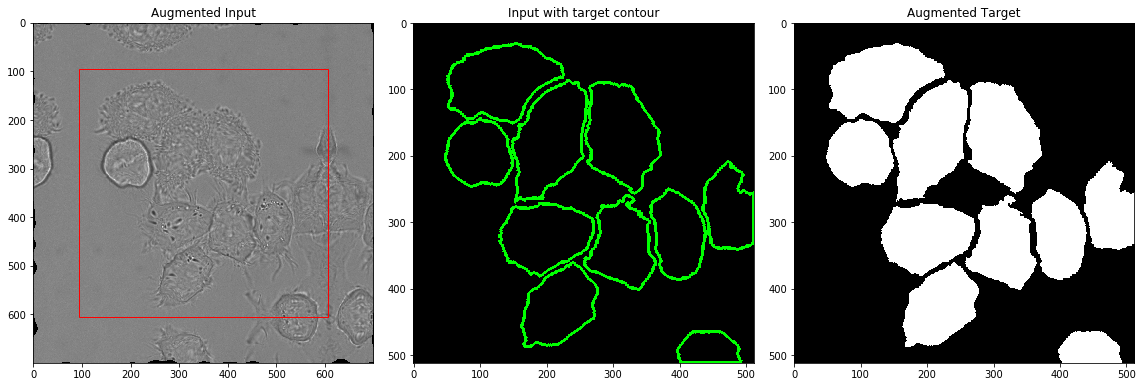

In [3]:
root_dir = os.path.join(CUR_DIR, "data", f"{DATASET}-training")
data = ImageDataset(root_dir, alpha=200, sigma=10, ISBI2012=ISBI2012)   # For training + validation

orig_img = cv.imread(os.path.join(root_dir, '01', os.listdir(os.path.join(root_dir, "01"))[0]), -1)

img, gt = data[0]

original_size, input_size, _ = input_size_compute(gt)
pad = int((input_size - original_size) / 2)

fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)

rect = patches.Rectangle((pad,pad),original_size,original_size,linewidth=1,edgecolor='r',facecolor='none')
gt = gt.reshape(gt.shape[1:]).numpy().astype(np.uint8)
contours, hierarchy = cv.findContours(gt, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
image = cv.cvtColor(img.reshape(img.shape[1:])[pad:pad+original_size,pad:pad+original_size].numpy().astype(np.uint8),cv.COLOR_GRAY2RGB)
cv.drawContours(image, contours, -1, (0, 255, 0), 3)

ax0.imshow(img.reshape(img.shape[1:]), cmap='gray')
ax0.add_patch(rect)
ax0.set_title('Augmented Input')
ax1.imshow(image)
ax1.set_title('Input with target contour')
ax2.imshow(gt, cmap='gray')
ax2.set_title('Augmented Target')

fig.tight_layout()
plt.show()

# Training

In [4]:
# Parameters:
val_per = 0.2
tr_per  = 1.0 - val_per
batch_size = 1
epochs = 2

In [5]:
root_dir = os.path.join(CUR_DIR, "data", "DIC-C2DH-HeLa-training")
train_dataset = ImageDataset(root_dir, alpha=200, sigma=10, ISBI2012=ISBI2012)   # For training + validation

samp_tr  = int(np.round(tr_per  * len(train_dataset)))
samp_val = int(np.round(val_per * len(train_dataset)))

# We round numbers so that we do not exceed total number of samples
while samp_tr + samp_val > len(train_dataset):
    samp_val += -1

# We generate an order vector to shuffle the samples before each fold for the cross validation  
order = np.arange(len(train_dataset))
np.random.shuffle(order)

# Suffle the training set
train_dataset = [train_dataset[idx] for idx in order]

# Divide between training and validation sets by order (in notebook we only use a few images for speed purposes)
train_set = train_dataset[0:2]
val_set   = train_dataset[2:3]

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=True)

# Shift values in order for next fold of cross validation (a shift of samp_val)
order = np.append(order[samp_val:], order[0:samp_val])
        
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on the GPU')

else:
    device = torch.device('cpu')
    print('Running on the CPU')

Running on the CPU


In [6]:
# To be called as: training(unet, train_loader, val_loader, epochs, batch_size, device, fold_dir):

train_dir = os.path.join(CUR_DIR, 'nb_train')
maybe_mkdir_p(train_dir)

torch.cuda.empty_cache()
unet = Unet().to(device)

optimizer = optim.SGD(unet.parameters(), lr=0.01, momentum=0.99)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, threshold=1e-5, eps=1e-6)
my_patience = 0

for epoch in range(epochs+1):
    
    print(' ')
    print('Epoch:', epoch)

    start = time()
    total_loss = 0
    previous_loss = 0
    total_loss_val = 0
    previous_loss_val = 0
    start_eval_train = 0
    start_eval_val = 0

    for batch in train_loader:

        optimizer.zero_grad()

        images, labels = batch
        preds = unet(images.to(device)) # pass batch to the unet

        pad = int((preds.shape[-1] - labels.shape[-1]) / 2)
        preds = preds[:, :, pad:labels.shape[-1]+pad, pad:labels.shape[-1]+pad]

        ll = torch.empty_like(preds)
        ll[:,0,:,:] = 1 - labels[:, 0, :, :]  # background
        ll[:,1,:,:] = labels[:, 0, :, :]  # cell
        ll = ll.to(device)

        weight_maps = weighted_map(labels, batch_size).to(device)
        criterion = nn.BCEWithLogitsLoss(weight=weight_maps)
        loss = criterion(preds, ll)

        loss.backward() # compute the gradients using backprop
        optimizer.step() # update the weights

        total_loss += loss

        preds = preds.argmax(dim=1)

        for idx in range(preds.shape[0]):
            if start_eval_train == 0 and idx == 0: # First time in epoch we initialize train_eval
                train_eval = evaluation_metrics(preds[idx, :, :].detach(), labels[idx, 0, :, :].detach())
                start_eval_train += 1
            else:
                np.concatenate((train_eval, evaluation_metrics(preds[idx, :, :].detach(), labels[idx, 0, :, :].detach())), axis=1)

    scheduler.step(total_loss / (len(train_loader) * batch_size)) # update the lr

    train_eval_epoch = np.mean(train_eval, axis=1)

    for batch in val_loader:
        
        images, labels = batch
        preds = unet(images.to(device))

        pad = int((preds.shape[-1] - labels.shape[-1]) / 2)
        preds = preds[:, :, pad:labels.shape[-1]+pad, pad:labels.shape[-1]+pad]

        ll = torch.empty_like(preds)
        ll[:,0,:,:] = 1 - labels[:, 0, :, :] # background
        ll[:,1,:,:] = labels[:, 0, :, :] # cell
        ll = ll.to(device)

        weight_maps = weighted_map(labels, batch_size).to(device)
        criterion = nn.BCEWithLogitsLoss(weight=weight_maps)
        loss = criterion(preds, ll)

        total_loss_val += loss

        preds = preds.argmax(1)

        for idx in range(preds.shape[0]):
            if start_eval_val == 0 and idx == 0: # First time in epoch we initialize val_eval
                val_eval = evaluation_metrics(preds[idx, :, :].detach(), labels[idx, 0, :, :].detach())
                start_eval_val += 1
            else:
                np.concatenate((val_eval, evaluation_metrics(preds[idx, :, :].detach(), labels[idx, 0, :, :].detach())), axis=1)

    val_eval_epoch = np.mean(val_eval, axis=1)

    for param_group in optimizer.param_groups: l_rate = param_group['lr']

    loss_epoch     = total_loss / (len(train_loader) * batch_size)
    loss_epoch_val = total_loss_val / (len(val_loader) * batch_size)
    loss_diff      = abs(previous_loss - loss_epoch)
    loss_diff_val  = abs(previous_loss_val - loss_epoch_val)

    if loss_diff < 1e-6: my_patience += 1
    
    previous_loss     = loss_epoch
    previous_loss_val = loss_epoch_val

    print('Current lr is:        ', l_rate                                )
    print('Patience is:           {}/10'.format(my_patience)              )
    print('Mean IoU training:    ', "{:.6f}".format(train_eval_epoch[0])  )
    print('Mean PE training:     ', "{:.6f}".format(train_eval_epoch[1])  )
    print('Mean IoU validation:  ', "{:.6f}".format(val_eval_epoch[0])    )
    print('Mean PE validation:   ', "{:.6f}".format(val_eval_epoch[1])    )
    print('Total training loss:  ', "{:.6f}".format(loss_epoch.item())    )
    print('Total validation loss:', "{:.6f}".format(loss_epoch_val.item()))
    print('Epoch duration:       ', "{:.6f}".format(time()-start), 's'    )
    print('                                                              ')

    # Save progress (evaluation metrics and loss)
    if epoch == 0:
        train_eval_progress_iou = [train_eval_epoch[0]]
        train_eval_progress_pe  = [train_eval_epoch[1]]
        val_eval_progress_iou   = [val_eval_epoch[0]]
        val_eval_progress_pe    = [val_eval_epoch[1]]
        loss_progress           = [loss_epoch.item()]
        loss_progress_val       = [loss_epoch_val.item()]
    elif epoch > 0:
        train_eval_progress_iou = np.concatenate((train_eval_progress_iou, [train_eval_epoch[0]]))
        train_eval_progress_pe  = np.concatenate((train_eval_progress_pe, [train_eval_epoch[1]]) )
        val_eval_progress_iou   = np.concatenate((val_eval_progress_iou, [val_eval_epoch[0]])    )
        val_eval_progress_pe    = np.concatenate((val_eval_progress_pe, [val_eval_epoch[1]])     )
        loss_progress           = np.append(loss_progress, [loss_epoch.item()]                   )
        loss_progress_val       = np.append(loss_progress_val, [loss_epoch_val.item()]           )

    np.savetxt(os.path.join(train_dir, 'train_eval_iou.out'), train_eval_progress_iou)
    np.savetxt(os.path.join(train_dir, 'train_eval_pe.out' ), train_eval_progress_pe )
    np.savetxt(os.path.join(train_dir, 'val_eval_iou.out'  ), val_eval_progress_iou  )
    np.savetxt(os.path.join(train_dir, 'val_eval_pe.out'   ), val_eval_progress_pe   )
    np.savetxt(os.path.join(train_dir, 'loss.out'          ), loss_progress          )
    np.savetxt(os.path.join(train_dir, 'loss_val.out'      ), loss_progress_val      )

    if l_rate < 1e-6 and my_patience == scheduler.patience:
            print('LR dropped below 1e-6!')
            print('Stopping training')
            break

    if my_patience == scheduler.patience: my_patience = 0

print('Training is finished as epoch {} has been reached'.format(epochs))


Epoch: 0
Current lr is:         0.01
Patience is:           0/10
Mean IoU training:     0.029681
Mean PE training:      0.001258
Mean IoU validation:   0.749799
Mean PE validation:    0.001236
Total training loss:   38.228775
Total validation loss: 9.609941
Epoch duration:        133.304142 s
                                                              
 
Epoch: 1
Current lr is:         0.01
Patience is:           0/10
Mean IoU training:     0.741532
Mean PE training:      0.001252
Mean IoU validation:   0.465270
Mean PE validation:    0.001398
Total training loss:   5.758669
Total validation loss: 3.430508
Epoch duration:        58.330467 s
                                                              
 
Epoch: 2
Current lr is:         0.01
Patience is:           0/10
Mean IoU training:     0.461816
Mean PE training:      0.001395
Mean IoU validation:   0.745545
Mean PE validation:    0.001233
Total training loss:   1.730642
Total validation loss: 2.172192
Epoch duration:        58.

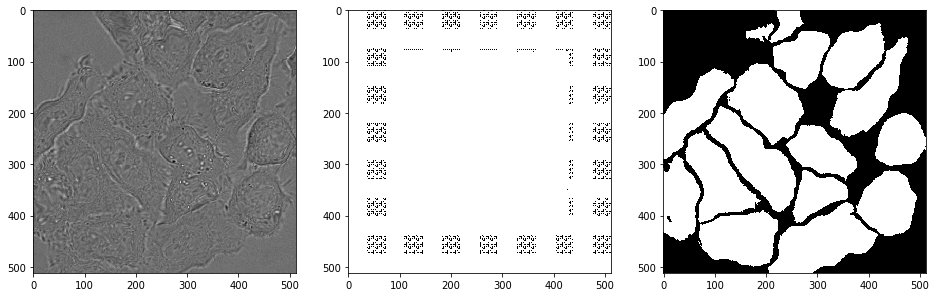

In [7]:
for i in range(1):
    fig = plt.figure(figsize=(16,9))
    ax0 = fig.add_subplot(131)
    ax1 = fig.add_subplot(132)
    ax2 = fig.add_subplot(133)

    original_size, input_size, _ = input_size_compute(gt)
    pad = int((input_size - original_size) / 2)

    ax0.imshow(images[0, 0, pad:original_size+pad, pad:original_size+pad].detach(), cmap='gray')
    ax1.imshow(preds[0, :, :].detach(), cmap='gray')
    ax2.imshow(labels[0, 0, :, :].detach(), cmap='gray')

# Testing

In [85]:
NETWORK = 'nb_test/unet_weight_save_5000.pth'
NETWORK = 'models/DIC-C2DH-HeLa/fold0/models/unet_weight_save_350.pth'
model_path = os.path.join(CUR_DIR, NETWORK)

In [86]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on the GPU')
else:
    device = torch.device('cpu')
    print('Running on the CPU')

# Get test data
test_dataset  = ImageDataset_test(root_dir, ISBI2012=ISBI2012)   
test_dataset  = [test_dataset[idx] for idx in range(len(test_dataset))]
test_set      = test_dataset[0: 1]                
test_loader   = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Make directory for test outputs (assumes .pth format)
output_dir = os.path.join(model_path[0:len(model_path)-4], '_test')
maybe_mkdir_p(output_dir)

torch.cuda.empty_cache()
unet = Unet().to(device)
unet.load_state_dict(torch.load(model_path, map_location=device))

Running on the CPU


<All keys matched successfully>

In [87]:
# To be called as: testing(unet, test_loader, batch_size, device, output_dir)

start = time()
start_eval_test = 0
idx = 0

maybe_mkdir_p(os.path.join(output_dir, 'images'))
maybe_mkdir_p(os.path.join(output_dir, 'preds' ))
maybe_mkdir_p(os.path.join(output_dir, 'labels'))

for batch in test_loader:
    
    image, label = batch

    pred = unet(image.to(device))

    pad = int((pred.shape[-1] - label.shape[-1]) / 2)
    pred = pred[:, :, pad:label.shape[-1]+pad, pad:label.shape[-1]+pad].argmax(dim=1)

    save_image(image[0, 0, :, :],         os.path.join(output_dir, 'images', f'image{idx}.tif'))
    save_image(label[0, 0, :, :].float(), os.path.join(output_dir, 'preds',  f'pred{idx}.tif' ))
    save_image(pred[0, :, :].float(),     os.path.join(output_dir, 'labels', f'label{idx}.tif'))

    if start_eval_test == 0: 
        test_eval = evaluation_metrics(pred[0, :, :].detach(), label[0, 0, :, :].detach())
        start_eval_test += 1
    else:
        np.concatenate((test_eval, evaluation_metrics(pred[0, :, :].detach(), label[0, 0, :, :].detach())), axis=1)

test = np.mean(test_eval, axis=1)

test_iou = [test[0]]
test_pe  = [test[1]]
np.savetxt(os.path.join(output_dir, 'test_iou.out'), test_iou)
np.savetxt(os.path.join(output_dir, 'test_pe.out' ), test_pe )

print('Mean IoU testing:', "{:.6f}".format(test[0])          )
print('Mean PE testing :', "{:.6f}".format(test[1])          )
print('Testing took    :', "{:.6f}".format(time()-start), 's')
print('                                                     ')

print('Testing is finished')

Mean IoU testing: 0.842702
Mean PE testing : 0.000737
Testing took    : 8.226671 s
                                                     
Testing is finished


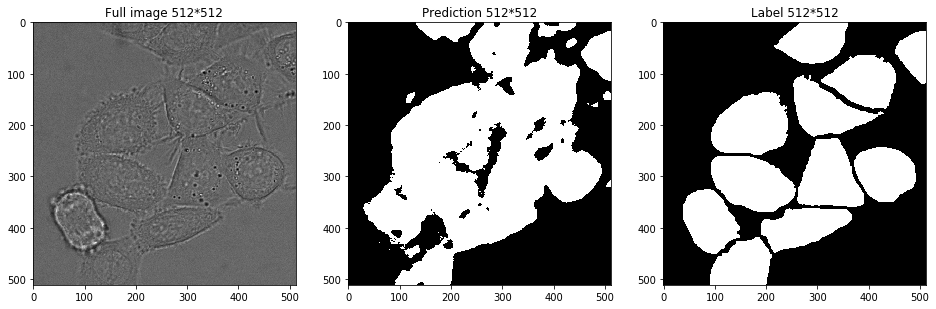

In [97]:
for i in range(1):
    fig = plt.figure(figsize=(16,9))
    ax0 = fig.add_subplot(131)
    ax1 = fig.add_subplot(132)
    ax2 = fig.add_subplot(133)

    pad = int((image.shape[-1] - label.shape[-1]) / 2)

    ax0.imshow(image[0, 0, pad:label.shape[-1]+pad, pad:label.shape[-1]+pad:].detach(), cmap='gray')
    ax1.imshow(pred[0, :, :].detach(),  cmap='gray')
    ax2.imshow(label[0, 0, :, :].detach(), cmap='gray')

    ax0.set_title('Full image 512*512')
    ax1.set_title('Prediction 512*512')
    ax2.set_title('Label 512*512')

In [108]:
np.random.seed(0)
order = np.arange(10)
np.random.shuffle(order)
print(order)

[2 8 4 9 1 6 7 3 0 5]


In [106]:
np.random.seed(0)

In [113]:
from functions import weighted_map

w = weighted_map(label, 1)
print(w.shape)

torch.Size([1, 1, 512, 512])


In [114]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(131)
ax0.imshow(w[0, 0, pad:label.shape[-1]+pad, pad:label.shape[-1]+pad:].detach(), cmap='jet')
ax0.set_title('Weighted map 512*512')

IndentationError: unexpected indent (<ipython-input-114-3351c83697b2>, line 2)